In [67]:
!nvidia-smi

Wed Jul 22 09:08:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    37W / 250W |   8739MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [68]:
from keras import datasets, Model
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, UpSampling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from keras.applications import InceptionResNetV2, NASNetLarge, ResNet50
from keras import optimizers
from keras import datasets

In [69]:
#load_data
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

#同時shuffle出訓練組及驗證組with different dimensions
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))  #permutation可shuffle一個給予的序列或是range，這裡給予len(a)，就是range也是a的index，所以a[p]就是以shuufle後的index重新排列的numpy array
    return a[p], b[p]
X_train, y_train = unison_shuffled_copies(X_train, y_train)
X_test, y_test = unison_shuffled_copies(X_test, y_test)

X_train = (X_train/255.0).astype("float32")
X_test = (X_test/255.0).astype("float32")

#Label 以one-hot encoder編碼
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [70]:
#using InceptionV2 have to add input_shape=(256,256,3) in conv_base, ResNet50, Xception, NASNetLarge did not.
# conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3))
#conv_base = InceptionResNetV2(weights='imagenet', include_top=False)
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [71]:
X_train.shape

(50000, 32, 32, 3)

In [72]:
#conv_base.summary()
len(conv_base.layers)

175

In [73]:
#conv_base = InceptionResNetV2(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(conv_base.output)
x = BatchNormalization()(x)
output = Dense(10, activation='softmax')(x)
model = Model(conv_base.input, output)
#設定凍結與要進行訓練的網路層
freeze_layers = 170
for layer in conv_base.layers[:freeze_layers]:
    layer.trainable = False
for layer in conv_base.layers[freeze_layers:]:
    layer.trainable = True
model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy']) #metrics, binary_crossentropy使用的是binary_accuracy，categorical_crossentropy使用的是categorical_accuracy
#callbacks_list = [ModelCheckpoint(filepath='test.hdf5', save_best_only=True), ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)]
history = model.fit(X_train, y_train, validation_split=0.3, epochs=50, shuffle=True)



Train on 35000 samples, validate on 15000 samples
Epoch 1/50
35000/35000 [==============================] - 31s 888us/step - loss: 0.2797 - accuracy: 0.9004 - val_loss: 0.5343 - val_accuracy: 0.8884
Epoch 2/50
35000/35000 [==============================] - 28s 789us/step - loss: 0.2411 - accuracy: 0.9100 - val_loss: 0.7279 - val_accuracy: 0.8203
Epoch 3/50
35000/35000 [==============================] - 28s 796us/step - loss: 0.2350 - accuracy: 0.9112 - val_loss: 0.6275 - val_accuracy: 0.8910
Epoch 4/50
35000/35000 [==============================] - 28s 792us/step - loss: 0.2296 - accuracy: 0.9131 - val_loss: 0.5420 - val_accuracy: 0.8863
Epoch 5/50
35000/35000 [==============================] - 28s 792us/step - loss: 0.2263 - accuracy: 0.9142 - val_loss: 0.7226 - val_accuracy: 0.8203
Epoch 6/50
35000/35000 [==============================] - 28s 810us/step - loss: 0.2221 - accuracy: 0.9148 - val_loss: 0.6626 - val_accuracy: 0.8199
Epoch 7/50
35000/35000 [==============================] 

In [74]:
def plot_loss_acc(X_test, y_test):
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("test_loss=", test_loss)
    print("test_acc=", test_acc)
    val_loss = history.history["val_loss"]
    loss = history.history["loss"]
    plt.plot(val_loss, label="val_loss")
    plt.plot(loss, label="loss")
    plt.hlines(y=test_loss, xmin=0, xmax=len(val_loss), colors='r', linestyles='--')
    plt.legend()
    plt.show()
    val_accuracy = history.history["val_accuracy"]
    accuracy = history.history["accuracy"]
    plt.plot(val_accuracy, label="val_accuracy")
    plt.plot(accuracy, label="accuracy")
    plt.hlines(y=test_acc, xmin=0, xmax=len(val_accuracy), colors='r', linestyles='--')
    plt.legend()
    plt.show()

10000/10000 [==============================] - 6s 574us/step
test_loss= 0.7502974460601807
test_acc= 0.8248396515846252


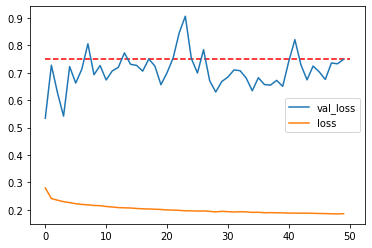

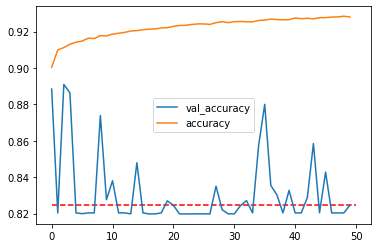

In [75]:
plot_loss_acc(X_test, y_test)